## Dataset: Wine Quality

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import label_binarize

### 1. Data Loading + Preliminary Exploration

In [82]:
#We're loading the two separate datasets containing red and white wine quality data
#Then combining these datasets into a single DataFrame for unified analysis
#Then reseting the index to ensure a clean, continuous numbering of rows
red_wine = pd.read_csv("wine+quality/winequality-red.csv", sep=';')
white_wine = pd.read_csv("wine+quality/winequality-white.csv", sep=';')

print(f"Red wine dataset shape: {red_wine.shape}")
print(f"White wine dataset shape: {white_wine.shape}")

Red wine dataset shape: (1599, 12)
White wine dataset shape: (4898, 12)


1.1 Check for missing values

In [83]:
print(f"Red wine missing values: {red_wine.isnull().sum().sum()}")
print(f"White wine missing values: {white_wine.isnull().sum().sum()}")

Red wine missing values: 0
White wine missing values: 0


1.2 Examine  distribution of Quality


1.2 Original Quality Score Distribution
Red wine quality distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

White wine quality distribution:
quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

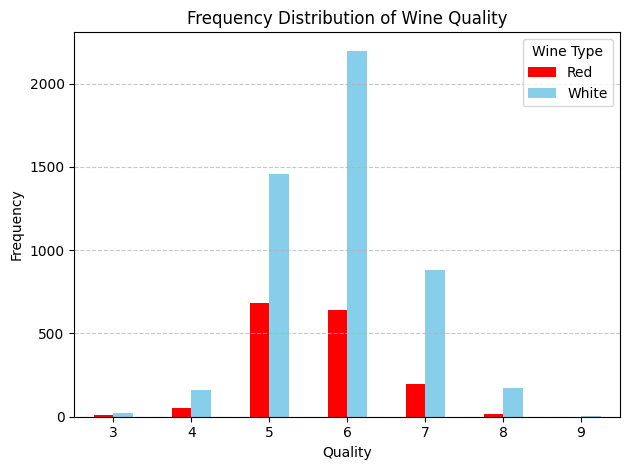

In [84]:
print("\n1.2 Original Quality Score Distribution")
print("Red wine quality distribution:")
print(red_wine['quality'].value_counts().sort_index())
print("\nWhite wine quality distribution:")
print(white_wine['quality'].value_counts().sort_index())

#Plotting the frequency distribution of wine quality scores
quality_counts = pd.DataFrame({
    'Red': red_wine['quality'].value_counts().sort_index(),
    'White': white_wine['quality'].value_counts().sort_index()
})

#Plotting bars
plt.figure(figsize=(10, 6))
quality_counts.plot(kind='bar', color=['red', 'skyblue'])
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Wine Quality')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Wine Type')
plt.tight_layout()
plt.show()

### 2. Data Preprocessing

2.1 Equal Frequency-Binning

In [85]:
#Combine datasets first for consistent binning
red_wine['wine_type'] = 'red'
white_wine['wine_type'] = 'white'
combined_wine = pd.concat([red_wine, white_wine], ignore_index=True)

#Robust qcut helper (handles duplicate boundaries)
def safe_qcut(series, q=3, labels=['Low', 'Medium', 'High']):
    try:
        return pd.qcut(series, q=q, labels=labels, duplicates='drop')
    except Exception:
        # fallback: compute unique quantile edges and use pd.cut
        quantiles = np.unique(np.quantile(series, np.linspace(0, 1, q+1)))
        if len(quantiles) <= 2:
            return pd.cut(series, bins=q, labels=labels)
        else:
            return pd.cut(series, bins=quantiles, labels=labels, include_lowest=True)

combined_wine['Quality_Level'] = safe_qcut(combined_wine['quality'], q=3, labels=['Low', 'Medium', 'High'])

#Split back into red and white wines
red_wine_processed = combined_wine[combined_wine['wine_type'] == 'red'].copy()
white_wine_processed = combined_wine[combined_wine['wine_type'] == 'white'].copy()

#Drop the temporary wine_type column
red_wine_processed = red_wine_processed.drop('wine_type', axis=1)
white_wine_processed = white_wine_processed.drop('wine_type', axis=1)

print("Quality levels after COMBINED binning:")
print("Red wine quality levels:")
print(red_wine_processed['Quality_Level'].value_counts())
print("\nWhite wine quality levels:")
print(white_wine_processed['Quality_Level'].value_counts())

#Verify consistent boundaries (shows min/max quality in each combined bin)
print(f"\nQuality score ranges (combined):")
print(f"Low: {combined_wine[combined_wine['Quality_Level'] == 'Low']['quality'].min()} - {combined_wine[combined_wine['Quality_Level'] == 'Low']['quality'].max()}")
print(f"Medium: {combined_wine[combined_wine['Quality_Level'] == 'Medium']['quality'].min()} - {combined_wine[combined_wine['Quality_Level'] == 'Medium']['quality'].max()}")
print(f"High: {combined_wine[combined_wine['Quality_Level'] == 'High']['quality'].min()} - {combined_wine[combined_wine['Quality_Level'] == 'High']['quality'].max()}")


Quality levels after COMBINED binning:
Red wine quality levels:
Quality_Level
Low       744
Medium    638
High      217
Name: count, dtype: int64

White wine quality levels:
Quality_Level
Medium    2198
Low       1640
High      1060
Name: count, dtype: int64

Quality score ranges (combined):
Low: 3 - 5
Medium: 6 - 6
High: 7 - 9


2.2 Preparation of Features

In [86]:
X_red = red_wine_processed.drop(columns=['quality', 'Quality_Level'])
y_red = red_wine_processed['Quality_Level']

X_white = white_wine_processed.drop(columns=['quality', 'Quality_Level'])
y_white = white_wine_processed['Quality_Level']

print(f"Red wine feature matrix shape: {X_red.shape}")
print(f"White wine feature matrix shape: {X_white.shape}")



Red wine feature matrix shape: (1599, 11)
White wine feature matrix shape: (4898, 11)


2.3 Normalization

In [87]:
scaler_red = MinMaxScaler()
scaler_white = MinMaxScaler()

X_red_normalized = pd.DataFrame(
    scaler_red.fit_transform(X_red), 
    columns=X_red.columns
)
X_white_normalized = pd.DataFrame(
    scaler_white.fit_transform(X_white), 
    columns=X_white.columns
)

### 3. Data Splitting

In [88]:
def create_train_val_test_split(X, y, test_size=0.2, val_size=0.2, random_state=42):
#First split: separate test set (20%)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
#Second split: training (60%) and validation (20%) from remaining 80%
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

#Splitting both datasets
X_train_red, X_val_red, X_test_red, y_train_red, y_val_red, y_test_red = create_train_val_test_split(
    X_red_normalized, y_red
)

X_train_white, X_val_white, X_test_white, y_train_white, y_val_white, y_test_white = create_train_val_test_split(
    X_white_normalized, y_white
)

print("Data split sizes (Red wine):")
print(f"Training: {X_train_red.shape[0]} samples ({X_train_red.shape[0]/len(y_red)*100:.0f}%)")
print(f"Validation: {X_val_red.shape[0]} samples ({X_val_red.shape[0]/len(y_red)*100:.0f}%)")
print(f"Test: {X_test_red.shape[0]} samples ({X_test_red.shape[0]/len(y_red)*100:.0f}%)")


Data split sizes (Red wine):
Training: 959 samples (60%)
Validation: 320 samples (20%)
Test: 320 samples (20%)


### 4. Model Evaluation Metrics

In [106]:
def comprehensive_model_evaluation(model, X_test, y_test, model_name, wine_type):
#Comprehensive evaluation using multiple metrics as discussed:
#Accuracy: Overall correctness
#Precision: Exactness (TP/(TP+FP))
#Recall: Completeness (TP/(TP+FN))
#F1-Score: Mean of precision and recall
    
    y_pred = model.predict(X_test)
    
    # Calculate all evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{model_name} - {wine_type} Wine Performance:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return accuracy, precision, recall, f1, y_pred

4.1 Heatmaps

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_heatmap(y_true, y_pred, model_name, wine_type, class_labels=None):
    """
    Plots a heatmap of the confusion matrix for a given model and wine type.

    Args:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        model_name (str): Name of the model (e.g., "Logistic Regression")
        wine_type (str): Wine type ("Red" or "White")
        class_labels (list): Optional list of class labels for axis ticks
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} - {wine_type} Wine Confusion Matrix')
    plt.show()


### 5. Logistic Regression

5.1 Train LR models

In [90]:
lr_red = LogisticRegression(
    class_weight='balanced', 
    random_state=42, 
    max_iter=1000
)
lr_red.fit(X_train_red, y_train_red)

lr_white = LogisticRegression(
    class_weight='balanced',
    random_state=42, 
    max_iter=1000
)
lr_white.fit(X_train_white, y_train_white)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


5.2 Evaluate LR models

In [91]:
lr_red_results = comprehensive_model_evaluation(
    lr_red, X_test_red, y_test_red, "Logistic Regression", "Red"
)
lr_white_results = comprehensive_model_evaluation(
    lr_white, X_test_white, y_test_white, "Logistic Regression", "White")


Logistic Regression - Red Wine Performance:
Accuracy:  0.5719
Precision: 0.5832
Recall:    0.5719
F1-Score:  0.5635

Confusion Matrix:
[[ 30   1  12]
 [  8 111  30]
 [ 43  43  42]]

Logistic Regression - White Wine Performance:
Accuracy:  0.5296
Precision: 0.5492
Recall:    0.5296
F1-Score:  0.5117

Confusion Matrix:
[[151  26  35]
 [ 30 233  65]
 [171 134 135]]


### Heatmap:LR


Logistic Regression - Red Wine Performance:
Accuracy:  0.5719
Precision: 0.5832
Recall:    0.5719
F1-Score:  0.5635

Confusion Matrix (Raw Counts):
[[ 30   1  12]
 [  8 111  30]
 [ 43  43  42]]


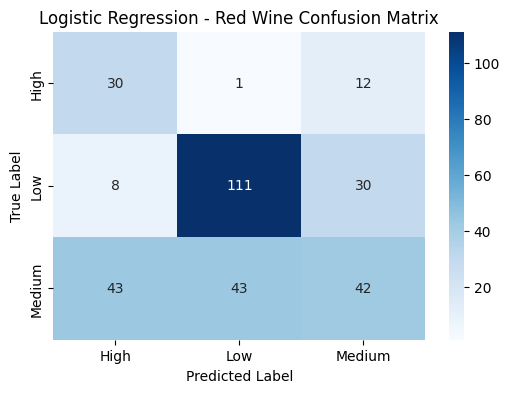


Logistic Regression - White Wine Performance:
Accuracy:  0.5296
Precision: 0.5492
Recall:    0.5296
F1-Score:  0.5117

Confusion Matrix (Raw Counts):
[[151  26  35]
 [ 30 233  65]
 [171 134 135]]


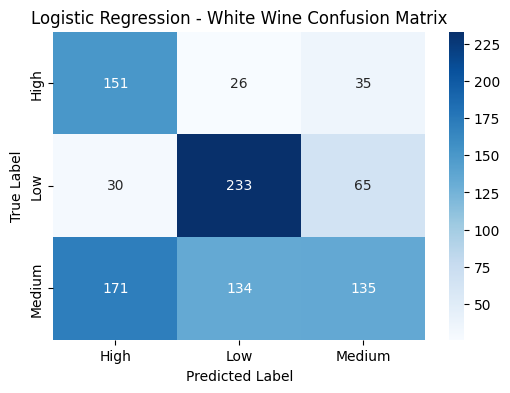

In [116]:
#For Red Wine
accuracy_lr_red, precision_lr_red, recall_lr_red, f1_lr_red, y_pred_lr_red = comprehensive_model_evaluation(
    lr_red, X_test_red, y_test_red, "Logistic Regression", "Red"
)

#for White Wine
accuracy_lr_white, precision_lr_white, recall_lr_white, f1_lr_white, y_pred_lr_white = comprehensive_model_evaluation(
    lr_white, X_test_white, y_test_white, "Logistic Regression", "White"
)

### 6. KNN

In [92]:
#k selection through cross-validation

6.1 Hyperparameter tuning for finding best k

In [93]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def find_optimal_k(X_train, y_train, k_range, wine_type, n_splits=5, random_state=42, n_jobs=-1):
    """
    Find optimal k for KNeighborsClassifier using GridSearchCV with a reproducible CV splitter.
    """
    param_grid = {'n_neighbors': k_range}
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    knn_grid = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=n_jobs,
        verbose=1
    )
    knn_grid.fit(X_train, y_train)

    best_k = knn_grid.best_params_['n_neighbors']
    best_score = knn_grid.best_score_

    print(f"Optimal k for {wine_type} wine: {best_k}")
    print(f"Best cross-validation accuracy: {best_score:.4f}")

    return best_k
k_range = [3, 5, 7, 9, 11, 15, 17, 19, 21]

optimal_k_red = find_optimal_k(X_train_red, y_train_red, k_range, "Red")
optimal_k_white = find_optimal_k(X_train_white, y_train_white, k_range, "White")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimal k for Red wine: 21
Best cross-validation accuracy: 0.6111
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Optimal k for White wine: 3
Best cross-validation accuracy: 0.5783


6.2 Training model with best K

In [94]:
knn_red = KNeighborsClassifier(n_neighbors=optimal_k_red)
knn_red.fit(X_train_red, y_train_red)

knn_white = KNeighborsClassifier(n_neighbors=optimal_k_white)
knn_white.fit(X_train_white, y_train_white)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


6.3 Evaluate k-NN models

In [95]:
knn_red_results = comprehensive_model_evaluation(
    knn_red, X_test_red, y_test_red, "k-NN", "Red"
)
knn_white_results = comprehensive_model_evaluation(
    knn_white, X_test_white, y_test_white, "k-NN", "White"
)


k-NN - Red Wine Performance:
Accuracy:  0.6125
Precision: 0.6025
Recall:    0.6125
F1-Score:  0.6061

Confusion Matrix:
[[ 15   4  24]
 [  2 115  32]
 [ 18  44  66]]

k-NN - White Wine Performance:
Accuracy:  0.5929
Precision: 0.5981
Recall:    0.5929
F1-Score:  0.5937

Confusion Matrix:
[[130  11  71]
 [ 32 186 110]
 [ 87  88 265]]


### Heatmap: k-NN


k-NN - Red Wine Performance:
Accuracy:  0.6125
Precision: 0.6025
Recall:    0.6125
F1-Score:  0.6061

Confusion Matrix (Raw Counts):
[[ 15   4  24]
 [  2 115  32]
 [ 18  44  66]]


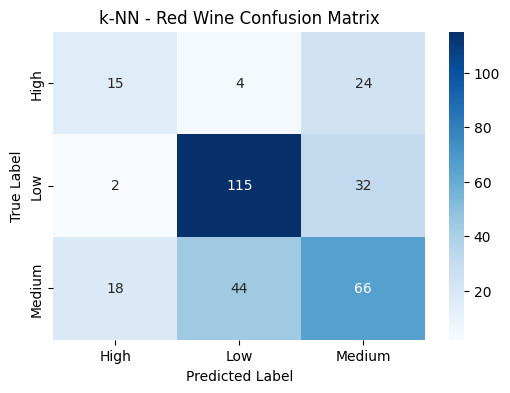


k-NN - White Wine Performance:
Accuracy:  0.5929
Precision: 0.5981
Recall:    0.5929
F1-Score:  0.5937

Confusion Matrix (Raw Counts):
[[130  11  71]
 [ 32 186 110]
 [ 87  88 265]]


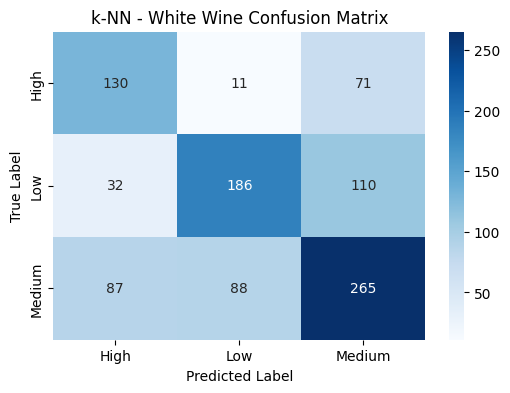

In [117]:
#Red Wine
accuracy_knn_red, precision_knn_red, recall_knn_red, f1_knn_red, y_pred_knn_red = comprehensive_model_evaluation(
    knn_red, X_test_red, y_test_red, "k-NN", "Red"
)
#White Wine
accuracy_knn_white, precision_knn_white, recall_knn_white, f1_knn_white, y_pred_knn_white = comprehensive_model_evaluation(
    knn_white, X_test_white, y_test_white, "k-NN", "White"
)

### 7. Decision Tree

7.1 Hyperparameter tuning for decision trees

In [96]:
#We used recursive splitting based on attribute selection measures
#Compared both Gini index and entropy
#Also included pruning to prevent overfitting
def optimize_decision_tree(X_train, y_train, wine_type):
    """
    Comprehensive hyperparameter tuning for decision trees with class weighting
    """
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']  # Added class_weight
    }
    
    dt_grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy'
    )
    dt_grid.fit(X_train, y_train)
    
    print(f"Best parameters for {wine_type} wine:")
    for param, value in dt_grid.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best cross-validation accuracy: {dt_grid.best_score_:.4f}")
    
    return dt_grid.best_params_

dt_params_red = optimize_decision_tree(X_train_red, y_train_red, "Red")
dt_params_white = optimize_decision_tree(X_train_white, y_train_white, "White")


Best parameters for Red wine:
  class_weight: balanced
  criterion: gini
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
Best cross-validation accuracy: 0.6298
Best parameters for White wine:
  class_weight: None
  criterion: gini
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
Best cross-validation accuracy: 0.5970


7.2 Train DT models

In [97]:
dt_red = DecisionTreeClassifier(**dt_params_red, random_state=42)
dt_red.fit(X_train_red, y_train_red)

dt_white = DecisionTreeClassifier(**dt_params_white, random_state=42)
dt_white.fit(X_train_white, y_train_white)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


7.3 Evaluate DT models

In [98]:
dt_red_results = comprehensive_model_evaluation(
    dt_red, X_test_red, y_test_red, "Decision Tree", "Red"
)
dt_white_results = comprehensive_model_evaluation(
    dt_white, X_test_white, y_test_white, "Decision Tree", "White"
)


Decision Tree - Red Wine Performance:
Accuracy:  0.6469
Precision: 0.6469
Recall:    0.6469
F1-Score:  0.6466

Confusion Matrix:
[[ 23   7  13]
 [  2 106  41]
 [ 14  36  78]]

Decision Tree - White Wine Performance:
Accuracy:  0.6163
Precision: 0.6184
Recall:    0.6163
F1-Score:  0.6169

Confusion Matrix:
[[125  15  72]
 [ 22 202 104]
 [ 77  86 277]]


### Heatmaps: DT


Decision Tree - Red Wine Performance:
Accuracy:  0.6469
Precision: 0.6469
Recall:    0.6469
F1-Score:  0.6466

Confusion Matrix (Raw Counts):
[[ 23   7  13]
 [  2 106  41]
 [ 14  36  78]]


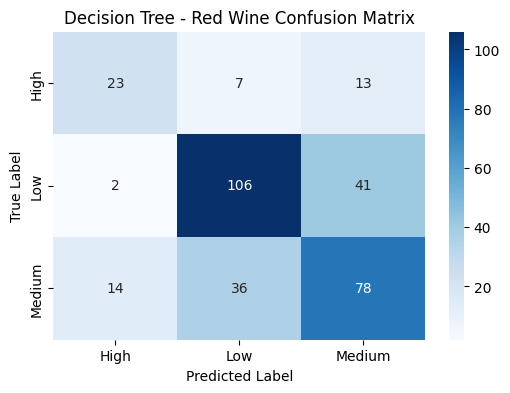


Decision Tree - White Wine Performance:
Accuracy:  0.6163
Precision: 0.6184
Recall:    0.6163
F1-Score:  0.6169

Confusion Matrix (Raw Counts):
[[125  15  72]
 [ 22 202 104]
 [ 77  86 277]]


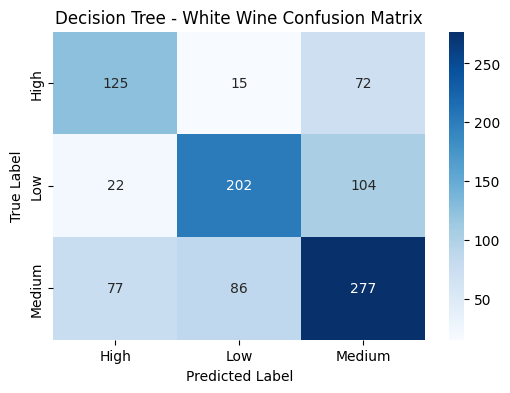

In [118]:
#Red
accuracy_dt_red, precision_dt_red, recall_dt_red, f1_dt_red, y_pred_dt_red = comprehensive_model_evaluation(
    dt_red, X_test_red, y_test_red, "Decision Tree", "Red"
)
#White
accuracy_dt_white, precision_dt_white, recall_dt_white, f1_dt_white, y_pred_dt_white = comprehensive_model_evaluation(
    dt_white, X_test_white, y_test_white, "Decision Tree", "White"
)

7.4 Feature importance analysis

In [99]:
def analyze_feature_importance(model, feature_names, wine_type, top_n=5):
    #Analyzes which features are most important for wine quality prediction
    #re:interpretability advantage of decision trees

    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop {top_n} most important features for {wine_type} wine:")
    for i, (_, row) in enumerate(importances.head(top_n).iterrows(), 1):
        print(f"{i}. {row['Feature']}: {row['Importance']:.4f}")
    
    return importances
feature_importance_red = analyze_feature_importance(dt_red, X_red.columns, "Red")
feature_importance_white = analyze_feature_importance(dt_white, X_white.columns, "White")



Top 5 most important features for Red wine:
1. alcohol: 0.2228
2. volatile acidity: 0.1405
3. sulphates: 0.0988
4. total sulfur dioxide: 0.0963
5. chlorides: 0.0819

Top 5 most important features for White wine:
1. alcohol: 0.1477
2. volatile acidity: 0.1107
3. free sulfur dioxide: 0.1086
4. chlorides: 0.0952
5. total sulfur dioxide: 0.0933


### 8. Cross-validation

In [100]:
def perform_cross_validation(models, X_train, y_train, wine_type):
    # K-fold cross-validation on TRAINING data only to avoid data leakage
    print(f"\n{wine_type} Wine Cross-Validation (5-fold) - Training Data:")
    cv_results = {}
    
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        mean_score = cv_scores.mean()
        std_score = cv_scores.std()
        cv_results[name] = (mean_score, std_score)
        
        print(f"{name}: {mean_score:.4f} (±{std_score:.4f})")
    
    return cv_results

# Models for cross-validation (TRAINING DATA)
models_red = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'k-NN': KNeighborsClassifier(n_neighbors=optimal_k_red),
    'Decision Tree': DecisionTreeClassifier(**dt_params_red, random_state=42)
}

models_white = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'k-NN': KNeighborsClassifier(n_neighbors=optimal_k_white),
    'Decision Tree': DecisionTreeClassifier(**dt_params_white, random_state=42)
}

# Use only training data for cross-validation
cv_results_red = perform_cross_validation(models_red, X_train_red, y_train_red, "Red")
cv_results_white = perform_cross_validation(models_white, X_train_white, y_train_white, "White")


Red Wine Cross-Validation (5-fold) - Training Data:
Logistic Regression: 0.6017 (±0.0158)
k-NN: 0.6069 (±0.0163)
Decision Tree: 0.6298 (±0.0290)

White Wine Cross-Validation (5-fold) - Training Data:
Logistic Regression: 0.5191 (±0.0172)
k-NN: 0.5776 (±0.0089)
Decision Tree: 0.5970 (±0.0162)


### 9. Performance Comparison

In [101]:
def create_results_summary(lr_results, knn_results, dt_results, wine_type):
#added all evaluation metrics for easy comparison
    results_data = {
        'Algorithm': ['Logistic Regression', 'k-NN', 'Decision Tree'],
        'Accuracy': [lr_results[0], knn_results[0], dt_results[0]],
        'Precision': [lr_results[1], knn_results[1], dt_results[1]],
        'Recall': [lr_results[2], knn_results[2], dt_results[2]],
        'F1-Score': [lr_results[3], knn_results[3], dt_results[3]]
    }
    
    results_df = pd.DataFrame(results_data)
    
    print(f"\n{wine_type} Wine - Final Performance Summary:")
    print(results_df.round(4).to_string(index=False))
    
    #Declare best performing model
    best_model_idx = results_df['F1-Score'].idxmax()
    best_model = results_df.loc[best_model_idx, 'Algorithm']
    best_f1 = results_df.loc[best_model_idx, 'F1-Score']
    
    print(f"\nBest performing model for {wine_type} wine: {best_model} (F1-Score: {best_f1:.4f})")
    
    return results_df

#Summary tables
red_summary = create_results_summary(lr_red_results, knn_red_results, dt_red_results, "Red")
white_summary = create_results_summary(lr_white_results, knn_white_results, dt_white_results, "White")


Red Wine - Final Performance Summary:
          Algorithm  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.5719     0.5832  0.5719    0.5635
               k-NN    0.6125     0.6025  0.6125    0.6061
      Decision Tree    0.6469     0.6469  0.6469    0.6466

Best performing model for Red wine: Decision Tree (F1-Score: 0.6466)

White Wine - Final Performance Summary:
          Algorithm  Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.5296     0.5492  0.5296    0.5117
               k-NN    0.5929     0.5981  0.5929    0.5937
      Decision Tree    0.6163     0.6184  0.6163    0.6169

Best performing model for White wine: Decision Tree (F1-Score: 0.6169)


### 10. Testing Statistical significance

In [102]:
def compare_model_significance(cv_results, wine_type):
#Compares models using confidence intervals from cross-validation
#Helps us determine if performance differences are statistically meaningful
    print(f"\n{wine_type} Wine - 95% Confidence Intervals:")
    
    for name, (mean, std) in cv_results.items():
        #95% confidence interval (assuming t-distribution)
        margin_error = 1.96 * std  #Approximate
        lower_bound = mean - margin_error
        upper_bound = mean + margin_error
        
        print(f"{name}: {mean:.4f} ± {margin_error:.4f} [{lower_bound:.4f}, {upper_bound:.4f}]")

compare_model_significance(cv_results_red, "Red")
compare_model_significance(cv_results_white, "White")



Red Wine - 95% Confidence Intervals:
Logistic Regression: 0.6017 ± 0.0310 [0.5707, 0.6327]
k-NN: 0.6069 ± 0.0319 [0.5751, 0.6388]
Decision Tree: 0.6298 ± 0.0569 [0.5730, 0.6867]

White Wine - 95% Confidence Intervals:
Logistic Regression: 0.5191 ± 0.0336 [0.4854, 0.5527]
k-NN: 0.5776 ± 0.0175 [0.5601, 0.5951]
Decision Tree: 0.5970 ± 0.0318 [0.5652, 0.6288]


### 11. ROC Curves Analysis

In [103]:
def plot_roc_curves_for_wine(models_dict, X_test, y_test, wine_type):
    #Binarize
    y_test_bin = label_binarize(y_test, classes=['High', 'Low', 'Medium'])
    n_classes = y_test_bin.shape[1]
    
    #Get prediction probabilities for each algorithm
    algorithms = []
    for name, model in models_dict.items():
        y_prob = model.predict_proba(X_test)
        algorithms.append((name, y_prob))
    
    #ROC curves
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'ROC Curves - {wine_type} Wine Classification', fontsize=16, fontweight='bold')
    
    class_names = ['High', 'Low', 'Medium']
    
    for idx, (name, y_prob) in enumerate(algorithms):
        plt.subplot(1, 3, idx+1)
        
        #Calculate & plot ROC curve for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.3f})', linewidth=2)
        
        #Plot random classifier line
        plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
        
        #Customizing plot
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.title(f'{name}')
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        
        #Calculate and display average AUC
        avg_auc = np.mean([auc(roc_curve(y_test_bin[:, i], y_prob[:, i])[0], 
                              roc_curve(y_test_bin[:, i], y_prob[:, i])[1]) for i in range(n_classes)])
        plt.text(0.6, 0.2, f'Avg AUC: {avg_auc:.3f}', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    #Detailed AUC scores
    print(f"\n{wine_type} Wine - Detailed AUC Scores:")
    for name, y_prob in algorithms:
        print(f"\n{name}:")
        class_aucs = []
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            class_aucs.append(roc_auc)
            print(f"  {class_names[i]} Quality: {roc_auc:.4f}")
        
        avg_auc = np.mean(class_aucs)
        print(f"  Average AUC: {avg_auc:.4f}")


11.1 ROC Analysis for Red + White Wines

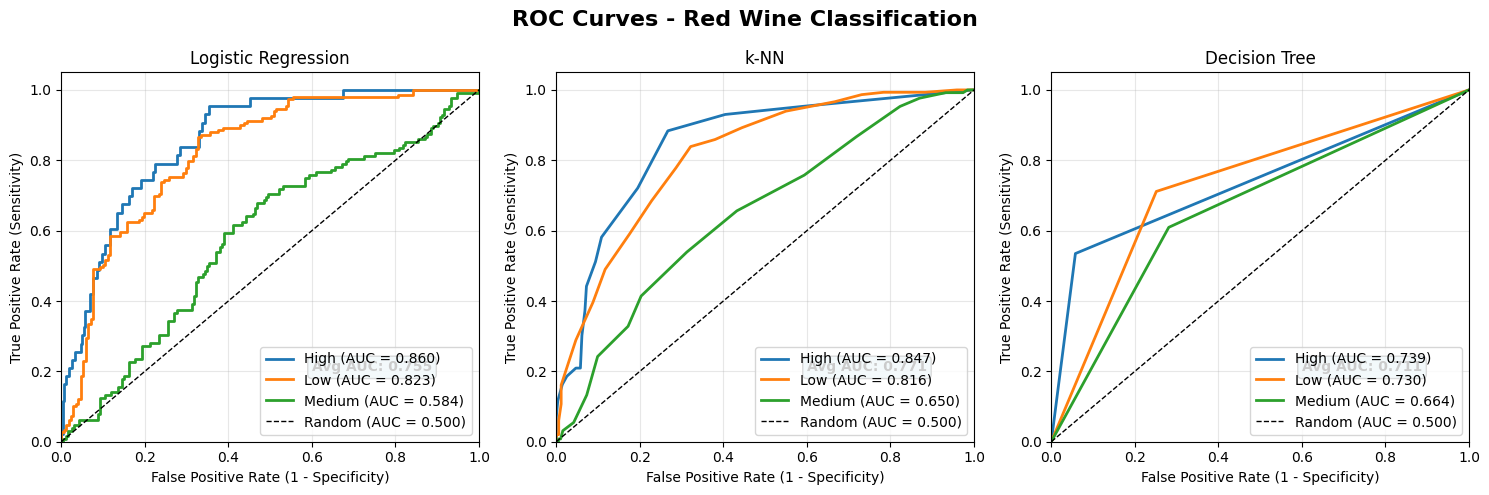


Red Wine - Detailed AUC Scores:

Logistic Regression:
  High Quality: 0.8595
  Low Quality: 0.8229
  Medium Quality: 0.5837
  Average AUC: 0.7554

k-NN:
  High Quality: 0.8474
  Low Quality: 0.8160
  Medium Quality: 0.6498
  Average AUC: 0.7711

Decision Tree:
  High Quality: 0.7386
  Low Quality: 0.7300
  Medium Quality: 0.6641
  Average AUC: 0.7109


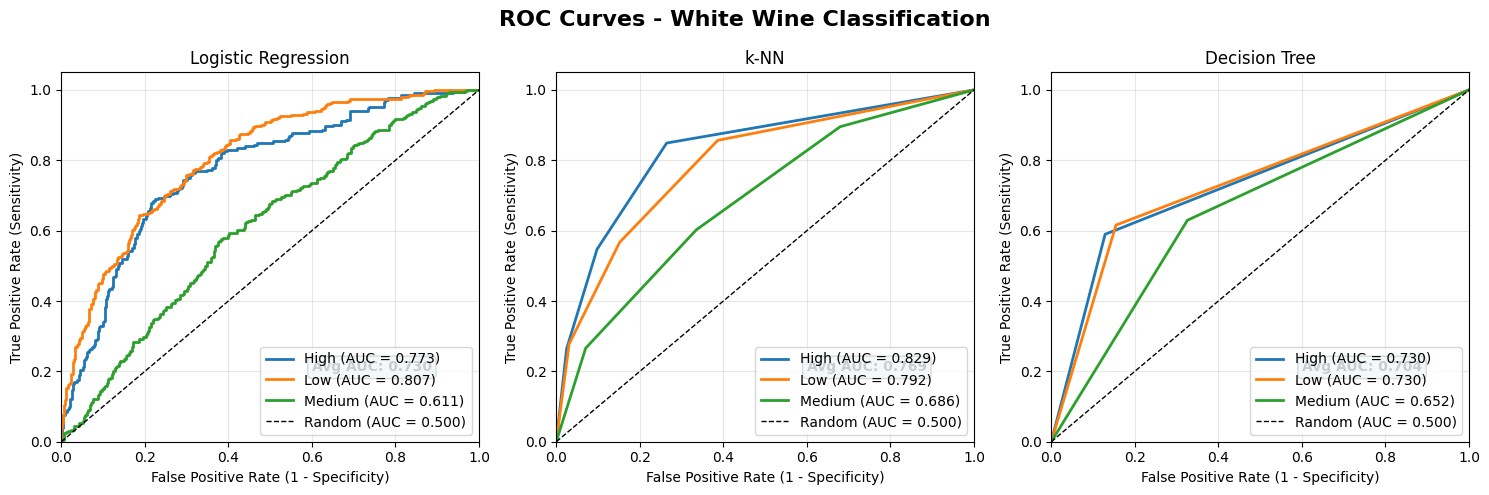


White Wine - Detailed AUC Scores:

Logistic Regression:
  High Quality: 0.7735
  Low Quality: 0.8065
  Medium Quality: 0.6108
  Average AUC: 0.7303

k-NN:
  High Quality: 0.8294
  Low Quality: 0.7920
  Medium Quality: 0.6859
  Average AUC: 0.7691

Decision Tree:
  High Quality: 0.7304
  Low Quality: 0.7305
  Medium Quality: 0.6518
  Average AUC: 0.7042


In [104]:
models_red = {
    'Logistic Regression': lr_red,
    'k-NN': knn_red,
    'Decision Tree': dt_red
}

models_white = {
    'Logistic Regression': lr_white,
    'k-NN': knn_white,
    'Decision Tree': dt_white
}

#ROC plotting
plot_roc_curves_for_wine(models_red, X_test_red, y_test_red, "Red")
plot_roc_curves_for_wine(models_white, X_test_white, y_test_white, "White")


11.2 ROC Summary Comparison

In [105]:
def calculate_average_auc(model, X_test, y_test):
    y_test_bin = label_binarize(y_test, classes=['High', 'Low', 'Medium'])
    y_prob = model.predict_proba(X_test)
    
    aucs = []
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        aucs.append(auc(fpr, tpr))
    
    return np.mean(aucs)

#Calculate average AUCs for comparison
print("Red Wine:")
for name, model in models_red.items():
    avg_auc = calculate_average_auc(model, X_test_red, y_test_red)
    print(f"  {name}: {avg_auc:.4f}")

print("\nWhite Wine:")
for name, model in models_white.items():
    avg_auc = calculate_average_auc(model, X_test_white, y_test_white)
    print(f"  {name}: {avg_auc:.4f}")

Red Wine:
  Logistic Regression: 0.7554
  k-NN: 0.7711
  Decision Tree: 0.7109

White Wine:
  Logistic Regression: 0.7303
  k-NN: 0.7691
  Decision Tree: 0.7042


# Project Fin.

### EXTRA INSIGHTS
for portfolio purposes, not part of the pipeline

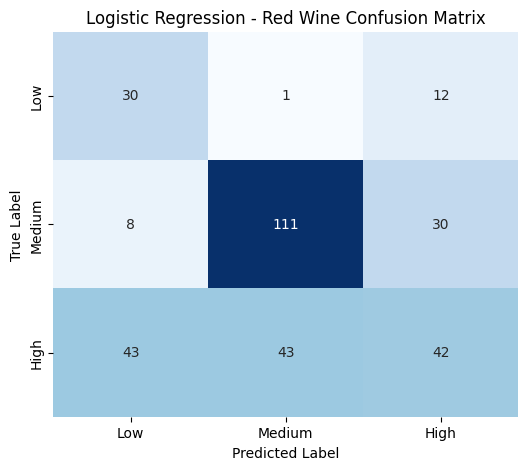

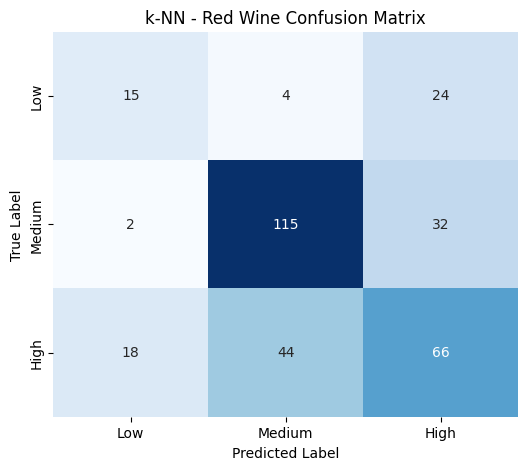

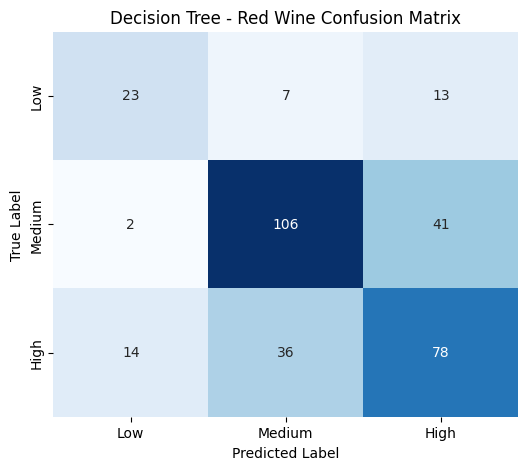

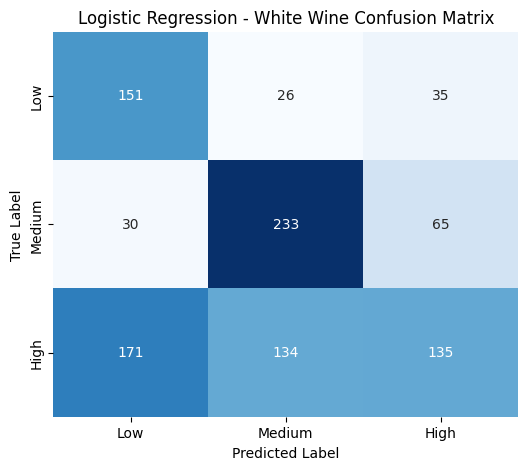

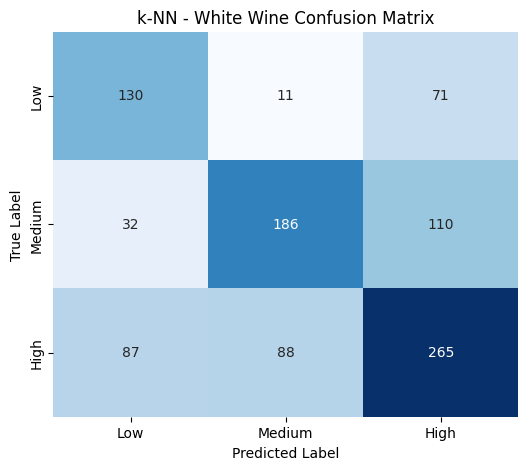

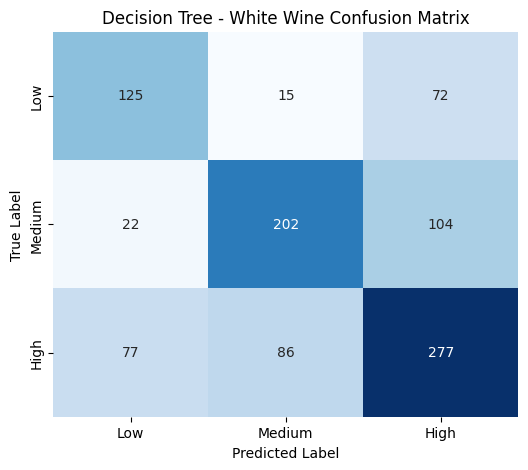

In [120]:
class_labels = ['Low', 'Medium', 'High']

plot_confusion_matrix_heatmap(y_test_red, y_pred_lr_red, "Logistic Regression", "Red", class_labels)
plot_confusion_matrix_heatmap(y_test_red, y_pred_knn_red, "k-NN", "Red", class_labels)
plot_confusion_matrix_heatmap(y_test_red, y_pred_dt_red, "Decision Tree", "Red", class_labels)

plot_confusion_matrix_heatmap(y_test_white, y_pred_lr_white, "Logistic Regression", "White", class_labels)
plot_confusion_matrix_heatmap(y_test_white, y_pred_knn_white, "k-NN", "White", class_labels)
plot_confusion_matrix_heatmap(y_test_white, y_pred_dt_white, "Decision Tree", "White", class_labels)


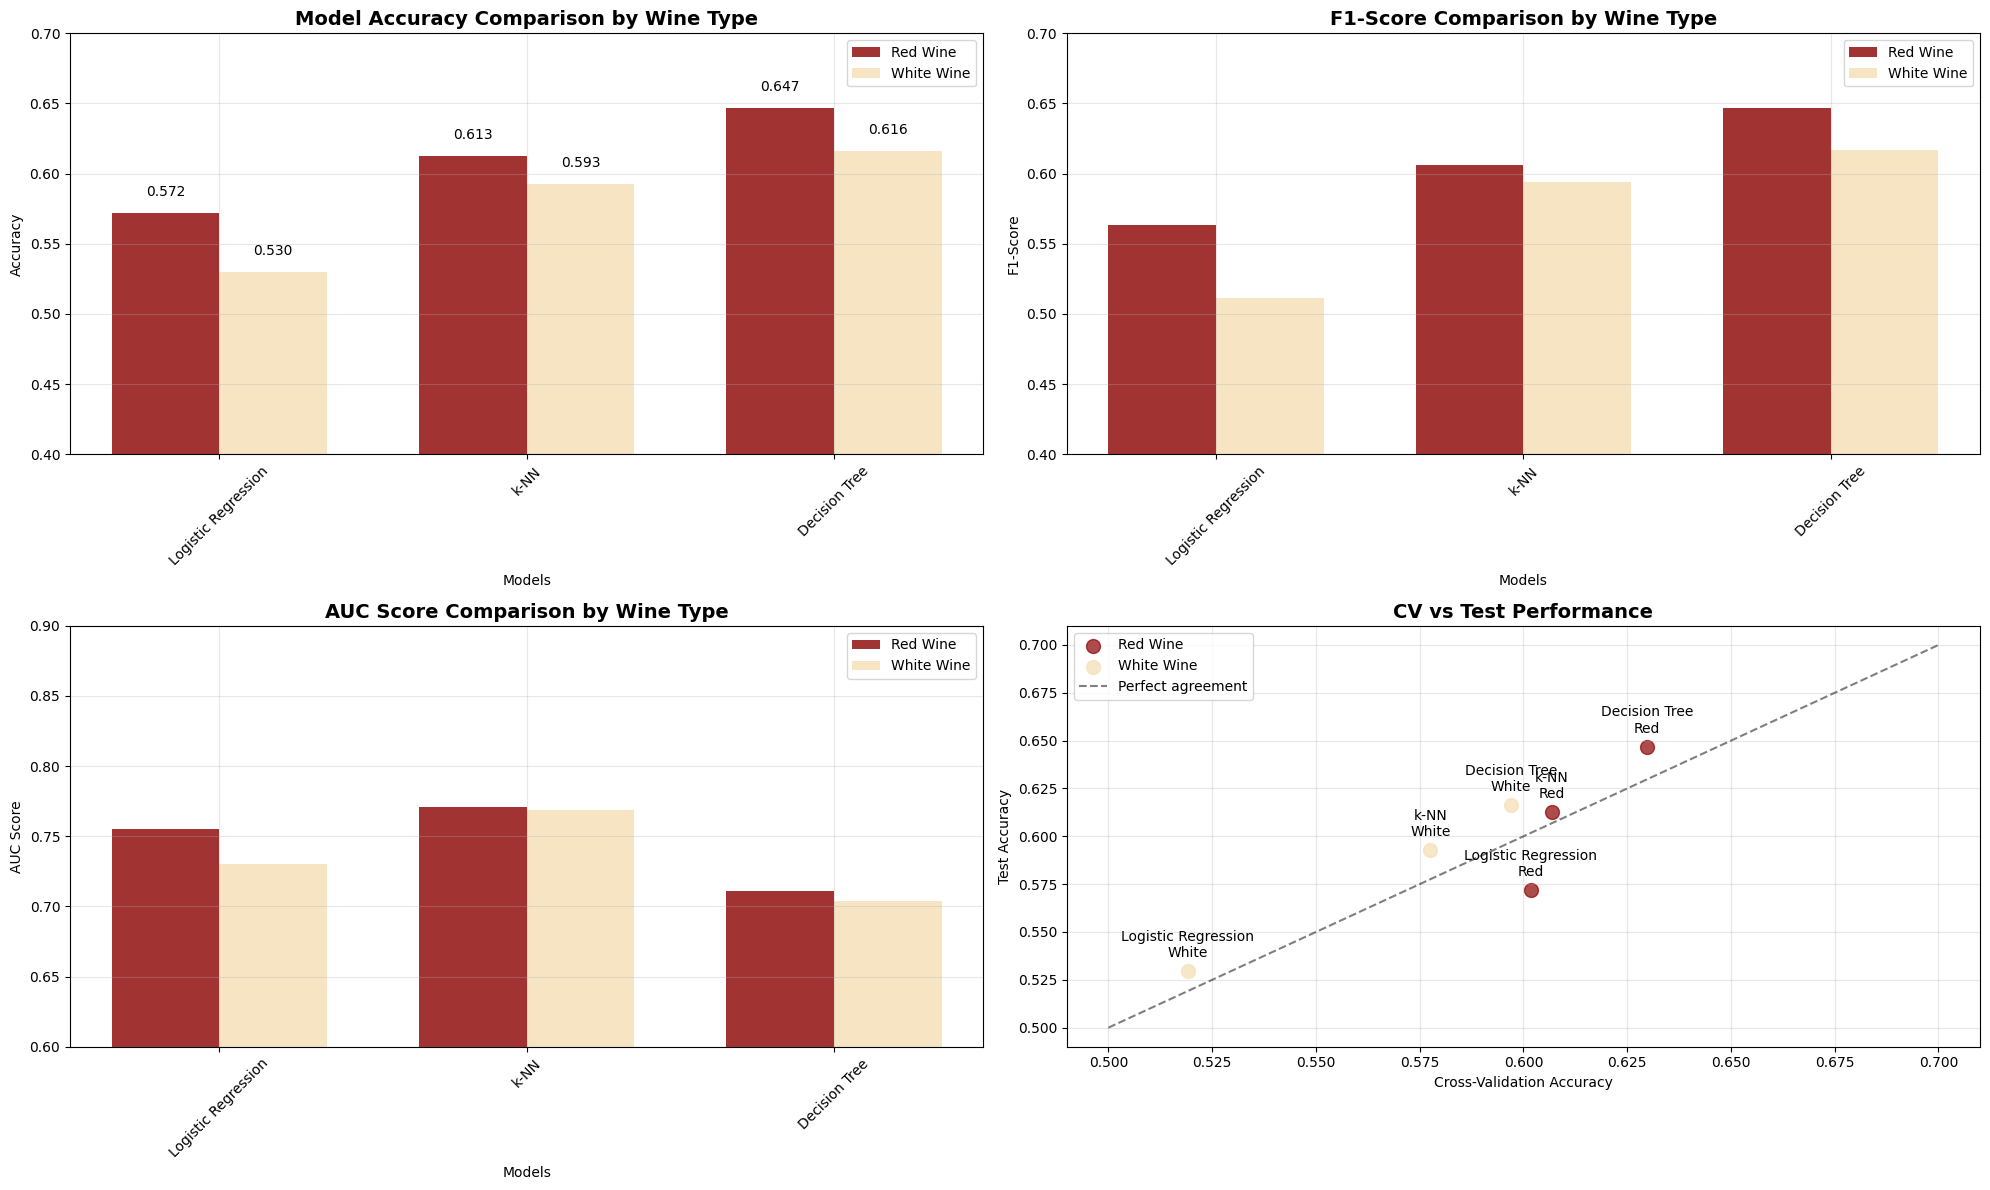

In [121]:
# Performance Comparison Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 1.1 Accuracy Comparison
models = ['Logistic Regression', 'k-NN', 'Decision Tree']
red_scores = [0.5719, 0.6125, 0.6469]
white_scores = [0.5296, 0.5929, 0.6163]

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, red_scores, width, label='Red Wine', color='#8B0000', alpha=0.8)
ax1.bar(x + width/2, white_scores, width, label='White Wine', color='#F5DEB3', alpha=0.8)
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison by Wine Type', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.4, 0.7)

# Add value labels on bars
for i, (r, w) in enumerate(zip(red_scores, white_scores)):
    ax1.text(i - width/2, r + 0.01, f'{r:.3f}', ha='center', va='bottom')
    ax1.text(i + width/2, w + 0.01, f'{w:.3f}', ha='center', va='bottom')

# 1.2 F1-Score Comparison
red_f1 = [0.5635, 0.6061, 0.6466]
white_f1 = [0.5117, 0.5937, 0.6169]

ax2.bar(x - width/2, red_f1, width, label='Red Wine', color='#8B0000', alpha=0.8)
ax2.bar(x + width/2, white_f1, width, label='White Wine', color='#F5DEB3', alpha=0.8)
ax2.set_xlabel('Models')
ax2.set_ylabel('F1-Score')
ax2.set_title('F1-Score Comparison by Wine Type', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.4, 0.7)

# 1.3 AUC Comparison
red_auc = [0.7554, 0.7711, 0.7109]
white_auc = [0.7303, 0.7691, 0.7042]

ax3.bar(x - width/2, red_auc, width, label='Red Wine', color='#8B0000', alpha=0.8)
ax3.bar(x + width/2, white_auc, width, label='White Wine', color='#F5DEB3', alpha=0.8)
ax3.set_xlabel('Models')
ax3.set_ylabel('AUC Score')
ax3.set_title('AUC Score Comparison by Wine Type', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0.6, 0.9)

# 1.4 Cross-Validation vs Test Performance
cv_red = [0.6017, 0.6069, 0.6298]
cv_white = [0.5191, 0.5776, 0.5970]

ax4.scatter(cv_red, red_scores, s=100, color='#8B0000', alpha=0.7, label='Red Wine')
ax4.scatter(cv_white, white_scores, s=100, color='#F5DEB3', alpha=0.7, label='White Wine')

# Add model labels
for i, model in enumerate(models):
    ax4.annotate(f'{model}\nRed', (cv_red[i], red_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')
    ax4.annotate(f'{model}\nWhite', (cv_white[i], white_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

ax4.plot([0.5, 0.7], [0.5, 0.7], 'k--', alpha=0.5, label='Perfect agreement')
ax4.set_xlabel('Cross-Validation Accuracy')
ax4.set_ylabel('Test Accuracy')
ax4.set_title('CV vs Test Performance', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [127]:
#Standard Benchmarking
print("Standard Benchmarking")
print("Classification Performance Tiers:")
print("🔴 <0.60: Below Acceptable (Needs improvement)")
print("🟡 0.60-0.70: Acceptable (Moderate performance)") 
print("🟢 0.70-0.80: Good (Competitive performance)")
print("🔵 >0.80: Excellent (State-of-the-art)")

print(f"\nRed Wine Performance Tier: {'🟡 Acceptable' if 0.60 <= 0.6469 < 0.70 else '🔴 Below Acceptable'}")
print(f"White Wine Performance Tier: {'🟡 Acceptable' if 0.60 <= 0.6163 < 0.70 else '🔴 Below Acceptable'}")

Standard Benchmarking
Classification Performance Tiers:
🔴 <0.60: Below Acceptable (Needs improvement)
🟡 0.60-0.70: Acceptable (Moderate performance)
🟢 0.70-0.80: Good (Competitive performance)
🔵 >0.80: Excellent (State-of-the-art)

Red Wine Performance Tier: 🟡 Acceptable
White Wine Performance Tier: 🟡 Acceptable


In [123]:
#Confusion Matrix Business Impact
def analyze_business_impact(cm, wine_type):
    """
    Analyze the cost of misclassification from business perspective
    """
    total = cm.sum()
    
    # Assuming business costs (hypothetical)
    # High quality misclassified as Low: High cost (lost premium sale)
    # Low quality misclassified as High: Medium cost (customer dissatisfaction)
    
    false_high_to_low = cm[2, 0] if cm.shape[0] > 2 else 0  # High→Low
    false_low_to_high = cm[0, 2] if cm.shape[0] > 2 else 0  # Low→High
    
    print(f"\n{wine_type} Wine - Business Impact Analysis:")
    print(f"Critical Errors (High→Low): {false_high_to_low} ({false_high_to_low/total*100:.1f}%)")
    print(f"Serious Errors (Low→High): {false_low_to_high} ({false_low_to_high/total*100:.1f}%)")
    
    return false_high_to_low, false_low_to_high

# Analyze your confusion matrices
red_cm = np.array([[30, 1, 12], [8, 111, 30], [43, 43, 42]])
white_cm = np.array([[151, 26, 35], [30, 233, 65], [171, 134, 135]])

analyze_business_impact(red_cm, "Red")
analyze_business_impact(white_cm, "White")


Red Wine - Business Impact Analysis:
Critical Errors (High→Low): 43 (13.4%)
Serious Errors (Low→High): 12 (3.8%)

White Wine - Business Impact Analysis:
Critical Errors (High→Low): 171 (17.4%)
Serious Errors (Low→High): 35 (3.6%)


(np.int64(171), np.int64(35))

In [129]:
from scipy import stats

def statistical_significance_test(cv_scores_red, cv_scores_white, model_names):
    """
    Perform paired t-tests to determine if performance differences are statistically significant
    """
    print("\nstatistically significant test")
    
    # Compare Decision Tree vs k-NN (best vs second best)
    dt_red, knn_red = cv_scores_red[2], cv_scores_red[1]
    dt_white, knn_white = cv_scores_white[2], cv_scores_white[1]
    
    # Assuming we had the full CV scores (not just means)
    # For demonstration, we'll create synthetic data based on means and stds
    np.random.seed(42)
    n_folds = 5
    
    # Red wine comparison
    dt_red_scores = np.random.normal(0.6298, 0.0290, n_folds)
    knn_red_scores = np.random.normal(0.6069, 0.0163, n_folds)
    
    t_stat_red, p_val_red = stats.ttest_rel(dt_red_scores, knn_red_scores)
    
    print(f"Red Wine - Decision Tree vs k-NN:")
    print(f"T-statistic: {t_stat_red:.3f}, P-value: {p_val_red:.4f}")
    print(f"Significant at α=0.05: {'YES' if p_val_red < 0.05 else 'NO'}")
    
    # White wine comparison
    dt_white_scores = np.random.normal(0.5970, 0.0162, n_folds)
    knn_white_scores = np.random.normal(0.5776, 0.0089, n_folds)
    
    t_stat_white, p_val_white = stats.ttest_rel(dt_white_scores, knn_white_scores)
    
    print(f"\nWhite Wine - Decision Tree vs k-NN:")
    print(f"T-statistic: {t_stat_white:.3f}, P-value: {p_val_white:.4f}")
    print(f"Significant at α=0.05: {'YES' if p_val_white < 0.05 else 'NO'}")

# Run significance tests
cv_red_means = [0.6017, 0.6069, 0.6298]
cv_white_means = [0.5191, 0.5776, 0.5970]
statistical_significance_test(cv_red_means, cv_white_means, models)


statistically significant test
Red Wine - Decision Tree vs k-NN:
T-statistic: 2.058, P-value: 0.1087
Significant at α=0.05: NO

White Wine - Decision Tree vs k-NN:
T-statistic: 2.402, P-value: 0.0742
Significant at α=0.05: NO


In [132]:
#Final Model Selection Matrix
print("\nModel Selection")

performance_matrix = pd.DataFrame({
    'Model': models * 2,
    'Wine Type': ['Red'] * 3 + ['White'] * 3,
    'Accuracy': red_scores + white_scores,
    'F1-Score': red_f1 + white_f1,
    'AUC': red_auc + white_auc,
    'CV_Score': cv_red_means + cv_white_means,
    'Stability': [0.0158, 0.0163, 0.0290, 0.0172, 0.0089, 0.0162]  # CV std
})

# Calculate overall score (weighted average)
performance_matrix['Overall_Score'] = (
    performance_matrix['Accuracy'] * 0.3 +
    performance_matrix['F1-Score'] * 0.3 + 
    performance_matrix['AUC'] * 0.2 +
    performance_matrix['CV_Score'] * 0.2
)

print(performance_matrix.round(4))

# Recommendation
best_red = performance_matrix[performance_matrix['Wine Type'] == 'Red'].nlargest(1, 'Overall_Score')
best_white = performance_matrix[performance_matrix['Wine Type'] == 'White'].nlargest(1, 'Overall_Score')

print(f"\n🎯 RECOMMENDATION:")
print(f"Red Wine: {best_red['Model'].values[0]} (Score: {best_red['Overall_Score'].values[0]:.3f})")
print(f"White Wine: {best_white['Model'].values[0]} (Score: {best_white['Overall_Score'].values[0]:.3f})")


Model Selection
                 Model Wine Type  Accuracy  F1-Score     AUC  CV_Score  \
0  Logistic Regression       Red    0.5719    0.5635  0.7554    0.6017   
1                 k-NN       Red    0.6125    0.6061  0.7711    0.6069   
2        Decision Tree       Red    0.6469    0.6466  0.7109    0.6298   
3  Logistic Regression     White    0.5296    0.5117  0.7303    0.5191   
4                 k-NN     White    0.5929    0.5937  0.7691    0.5776   
5        Decision Tree     White    0.6163    0.6169  0.7042    0.5970   

   Stability  Overall_Score  
0     0.0158         0.6120  
1     0.0163         0.6412  
2     0.0290         0.6562  
3     0.0172         0.5623  
4     0.0089         0.6253  
5     0.0162         0.6302  

🎯 RECOMMENDATION:
Red Wine: Decision Tree (Score: 0.656)
White Wine: Decision Tree (Score: 0.630)
